In [1]:
from astropy.table import Table, column, vstack
import astropy.units as u
import numpy as np

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
s4g = Table.read('fits/s4g_halo_table_matched.fits')
sdss = Table.read('fits/sdss_halo_table_matched.fits')
sdss_w_gas = Table.read('fits/sdss_w_gas_table_matched.fits')

masks = Table.read('fits/masks.fits')

morph_data = Table.read('fits/morph_data.fits')

In [3]:
in_s4g = s4g['unbarred_sample']
in_sdss = masks['z<0.085 (+HI unbarred spiral)']

#### Can simulations predict 'realistic' spiral galaxies, or do they simply produce many-arm modal structures?

In [4]:
from scipy.stats import anderson_ksamp, ks_2samp, ttest_ind

class ComparisonPlotter():
    
    def __init__(self,comparison_x,bins,titles,n_subsets=3,
                 median_line=False,mean_line=False):
        if len(comparison_x) == n_subsets:
            self.comparison_x = comparison_x
        else:
            self.comparison_x = [comparison_x for n in range(n_subsets)]
        self.bins = bins
        self.titles = titles
        self.median_line = median_line
        self.mean_line = mean_line
        self.n_subsets = n_subsets
        
    def make_axes(self,xlabel='x',ylabel='y',dlabels='_nolabel_',
                  plot_comparison=True):
        fig, axarr = plt.subplots(self.n_subsets,1,
                                  figsize=(10,4*self.n_subsets),
                                  sharex=True,sharey=True)
        axarr[-1].set_xlabel(xlabel)
        self.fig = fig
        self.axarr = axarr
        self.axarr[-1].set_xlim(self.bins[0],self.bins[-1])
        fig.subplots_adjust(hspace=0)
        
        letters = 'abcdefghijklmnopqrstuvwxyz'
        
        for ax, letter, title, x, dlabel in zip(
            axarr,letters,self.titles,self.comparison_x,dlabels):
            if plot_comparison is True:
                _ = ax.hist(x,self.bins,normed=True,
                            histtype='stepfilled',color='k',alpha=0.2,
                            label=dlabel)
                _ = ax.hist(x,self.bins,normed=True,
                            histtype='step',color='k',lw=1,
                            label='_nolegend_')
                if self.median_line is True:
                    median_x = np.median(x)
                    plt.sca(ax)
                    _ = plt.axvline(median_x,color='k',lw=1,
                                    linestyle='dotted',label='_nolegend_')
                if self.mean_line is True:
                    mean_x = np.mean(x)
                    plt.sca(ax)
                    _ = plt.axvline(mean_x,color='k',lw=1,
                                    linestyle='dotted',label='_nolegend_')
            _ = ax.set_ylabel(ylabel)         
            _ = ax.text(0.025,0.95,'({}) {}'.format(letter,title),
                        transform=ax.transAxes,va='top',ha='left',zorder=10)
        
        return self.fig, self.axarr
    
    def histogram(self,data_list,histtype='step',**kwargs):
        for ax, d in zip(self.axarr,data_list):
            _ = ax.hist(d,self.bins,normed=True,
                        histtype=histtype,label='_nolegend_',**kwargs)
            
            if self.median_line is True:
                median_d = np.median(d)
                plt.sca(ax)
                _ = plt.axvline(median_d,label='_nolegend_',**kwargs)
            if self.mean_line is True:
                mean_d = np.mean(d)
                plt.sca(ax)
                _ = plt.axvline(mean_d,label='_nolegend_',**kwargs)
        return None
    
    def ks_score(self,data_list):
        ks_values = []
        p_values = []
        for d, d2 in zip(data_list, self.comparison_x):
            k, p = ks_2samp(d,d2)
            ks_values.append(k)
            p_values.append(p)
        return ks_values, p_values
    
    def t_score(self,data_list):
        t_values = []
        p_values = []
        for d, d2 in zip(data_list, self.comparison_x):
            t, p = ttest_ind(d,d2,equal_var=False) # Welch's
            t_values.append(t)
            p_values.append(p)
        return t_values, p_values 
    
    def percentiles(self,data_list,percentiles=(16,50,84),error=True):
        percentile_array = np.zeros((len(data_list),len(percentiles)))
        for i, d in enumerate(data_list):
            percentile_array[i] = [np.percentile(d,p) 
                                     for p in percentiles]
            
        if error is True: # this changes the upper and lower percentiles
            # to +/- style values.
            percentile_array[:,0] = (percentile_array[:,1] 
                                   - percentile_array[:,0])
            percentile_array[:,2] = (percentile_array[:,2] 
                                   - percentile_array[:,1])
            
        return percentile_array
    
    def comparison_percentiles(self,percentiles=(16,50,84),error=True):
        percentile_array = np.zeros((self.n_subsets,len(percentiles)))
        for i, d in enumerate(self.comparison_x):
            percentile_array[i] = [np.percentile(d,p) 
                                     for p in percentiles]
            
        if error is True: # this changes the upper and lower percentiles
            # to +/- style values.
            percentile_array[:,0] = (percentile_array[:,1] 
                                   - percentile_array[:,0])
            percentile_array[:,2] = (percentile_array[:,2] 
                                   - percentile_array[:,1])
            
        return percentile_array
    
    def label_maker(self,data_list,label='Hernquist',ks=True,**kwargs):
        Ds, _ = self.ks_score(data_list)
        percents = self.percentiles(data_list,error=True)
        for i, (ax, D) in enumerate(zip(self.axarr,Ds)):
            percent = percents[i]
            label_list = [label,
                         np.round(D,decimals=2),
                         np.round(percent[1],decimals=2),
                         np.round(percent[2],decimals=2),
                         np.round(percent[0],decimals=2)]
            if ks is True:
                ax_label = r'{} ($D$={}, Med=${}^{{+{}}}_{{-{}}}$)'.format(
                                                                *label_list)
            else:
                _ = label_list.pop(1)
                ax_label = r'{} (Med=${}^{{+{}}}_{{-{}}}$)'.format(
                                                        *label_list)
            ax.plot([],[],label=ax_label,**kwargs)
        return None
    
    def errorbar(self,error_data_list,error_position=(0.1,0.8),
                 f_of_error=1,**kwargs):
        for ax, errors in zip(self.axarr,error_data_list):
            error = np.median(errors) * f_of_error
            x0, x1 = ax.get_xlim()
            y0, y1 = ax.get_ylim()
            if error_position[0] > 0.5:
                x_c = x0 + (x1-x0)*error_position[0] - error/2
            else:
                x_c = x0 + (x1-x0)*error_position[0] + error/2
            y_c = y0 + (y1-y0)*error_position[1]
            _ = ax.errorbar(x_c,y_c,xerr=error/2,**kwargs)
        return None

#### Spiral arm number... 

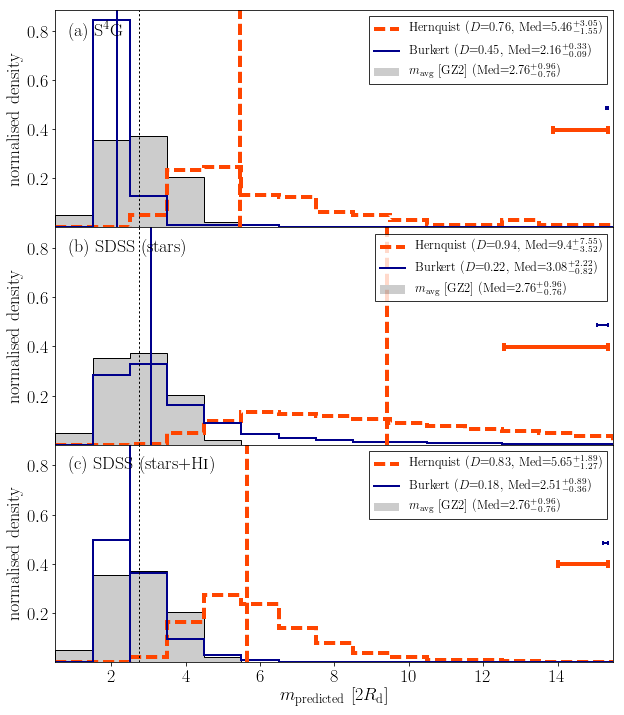

In [10]:
bins = np.linspace(0.5,15.5,16)
m_obs = np.array(morph_data['m'][in_sdss])
m_avg = morph_data['m_avg'][in_sdss]

c = ComparisonPlotter(m_avg,bins,[r'S$^4$G',
                                  r'SDSS (stars)',
                                  r'SDSS (stars+H\textsc{i})'],
                      n_subsets=3,median_line=True)

dh = [s4g['m_hernquist_2R_d'][in_s4g],
      sdss['m_hernquist_2R_d'][in_sdss],
      sdss_w_gas['m_hernquist_2R_d'][in_sdss]]

db = [s4g['m_burkert_2R_d'][in_s4g],
      sdss['m_burkert_2R_d'][in_sdss],
      sdss_w_gas['m_burkert_2R_d'][in_sdss]]

eh = [s4g['delta_m_hernquist_2R_d'][in_s4g],
      sdss['delta_m_hernquist_2R_d'][in_sdss],
      sdss_w_gas['delta_m_hernquist_2R_d'][in_sdss]]

eb = [s4g['delta_m_burkert_2R_d'][in_s4g],
      sdss['delta_m_burkert_2R_d'][in_sdss],
      sdss_w_gas['delta_m_burkert_2R_d'][in_sdss]]

################ labelling...
dlabels = []
p_array = c.comparison_percentiles(error=True)
labels = ('$m_\mathrm{avg}$ [GZ2]',
          '$m_\mathrm{avg}$ [GZ2]',
          '$m_\mathrm{avg}$ [GZ2]')
for i, label in enumerate(labels):
    p = p_array[i]
    p_list = [np.round(p[1],decimals=2),np.round(p[2],decimals=2),
              np.round(p[0],decimals=2)]
    dlabel = r'{} (Med=${}^{{+{}}}_{{-{}}}$)'.format(label,*p_list)
    dlabels.append(dlabel)
##################

_ = c.make_axes('$m_\mathrm{predicted}$ [2$R_\mathrm{d}$]',
                'normalised density',dlabels=dlabels)

c.histogram(dh,color='orangered',linestyle='dashed',lw=4,histtype='step')
c.histogram(db,color='darkblue',lw=2,linestyle='solid',histtype='step')

c.label_maker(dh,label='Hernquist',color='orangered',linestyle='dashed',lw=4)
c.label_maker(db,label='Burkert',color='darkblue',lw=2,linestyle='solid')

c.errorbar(eh,(0.99,0.45),0.5,
           color='orangered',linestyle='dashed',lw=4,
           capthick=4,capsize=4)
c.errorbar(eb,(0.99,0.55),0.5,
           color='darkblue',lw=2,linestyle='solid',
           capthick=2,capsize=2)

for ax in c.axarr:
    ax.legend(loc='upper right',fontsize=12.5,fancybox=False,edgecolor='k')
    
c.fig.savefig('figures/m_distributions.pdf')

#### Spiral arm pitch angle...

In [11]:
# Load the required data
gz2_psis = Table.read('../sparcfire2/fits/galaxy_level_all.fits')
has_psi_gz2 = gz2_psis['N_arcs'] >= 1

s4g_psis = Table.read('s4g_fits/psi_matched.fits')
has_psi_s4g = s4g_psis['P_abs'] > 0

In [12]:
# create the new masks:
in_sdss_psi = np.all([in_sdss,has_psi_gz2],axis=0)
in_s4g_psi = np.all([in_s4g,has_psi_s4g],axis=0)

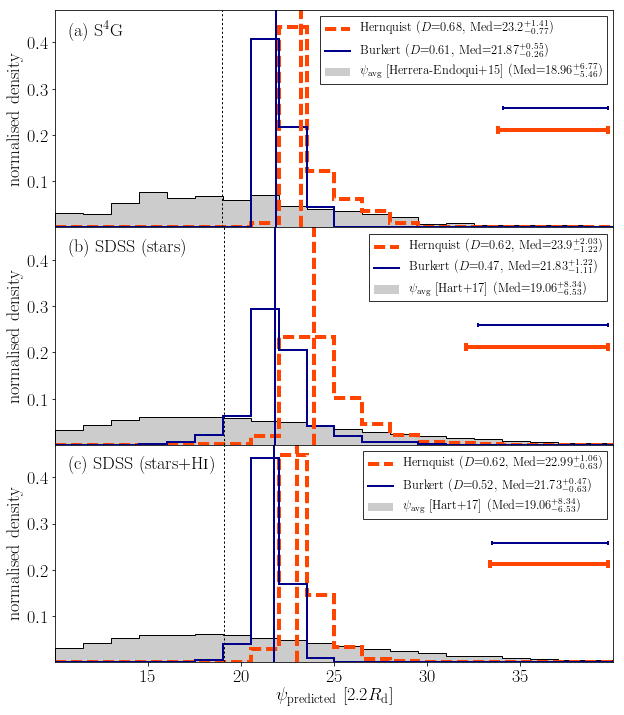

In [13]:
bins = np.linspace(10,40,21)
psi_obs = [np.array(s4g_psis['P_abs'][has_psi_s4g]),
           np.array(gz2_psis['P_wtd_avg'][has_psi_gz2]),
           np.array(gz2_psis['P_wtd_avg'][has_psi_gz2])]

c = ComparisonPlotter(psi_obs,bins,[r'S$^4$G',
                                  r'SDSS (stars)',
                                  r'SDSS (stars+H\textsc{i})'],
                      n_subsets=3,median_line=True)

dh = [s4g['psi_hernquist_michikoshi'][in_s4g_psi],
      sdss['psi_hernquist_michikoshi'][in_sdss_psi],
      sdss_w_gas['psi_hernquist_michikoshi'][in_sdss_psi]]

db = [s4g['psi_burkert_michikoshi'][in_s4g_psi],
      sdss['psi_burkert_michikoshi'][in_sdss_psi],
      sdss_w_gas['psi_burkert_michikoshi'][in_sdss_psi]]

eh = [s4g['delta_psi_hernquist_michikoshi'][in_s4g_psi],
      sdss['delta_psi_hernquist_michikoshi'][in_sdss_psi],
      sdss_w_gas['delta_psi_hernquist_michikoshi'][in_sdss_psi]]

eb = [s4g['delta_psi_burkert_michikoshi'][in_s4g_psi],
      sdss['delta_psi_burkert_michikoshi'][in_sdss_psi],
      sdss_w_gas['delta_psi_burkert_michikoshi'][in_sdss_psi]]
################ labelling...
dlabels = []
p_array = c.comparison_percentiles(error=True)
labels = ('$\psi_\mathrm{avg}$ [Herrera-Endoqui+15]',
          '$\psi_\mathrm{avg}$ [Hart+17]',
          '$\psi_\mathrm{avg}$ [Hart+17]')
for i, label in enumerate(labels):
    p = p_array[i]
    p_list = [np.round(p[1],decimals=2),np.round(p[2],decimals=2),
              np.round(p[0],decimals=2)]
    dlabel = r'{} (Med=${}^{{+{}}}_{{-{}}}$)'.format(label,*p_list)
    dlabels.append(dlabel)
##################
_ = c.make_axes('$\psi_\mathrm{predicted}$ [2.2$R_\mathrm{d}$]',
                'normalised density',dlabels=dlabels)

c.histogram(dh,color='orangered',linestyle='dashed',lw=4,histtype='step')
c.histogram(db,color='darkblue',lw=2,linestyle='solid',histtype='step')

c.label_maker(dh,label='Hernquist',color='orangered',linestyle='dashed',lw=4)
c.label_maker(db,label='Burkert',color='darkblue',lw=2,linestyle='solid')

c.errorbar(eh,(0.99,0.45),0.5,
           color='orangered',linestyle='dashed',lw=4,
           capthick=4,capsize=4)
c.errorbar(eb,(0.99,0.55),0.5,
           color='darkblue',lw=2,linestyle='solid',
           capthick=2,capsize=2)

for ax in c.axarr:
    ax.legend(fontsize=12.5,fancybox=False,edgecolor='k')
    
c.fig.savefig('figures/psi_distributions.pdf')

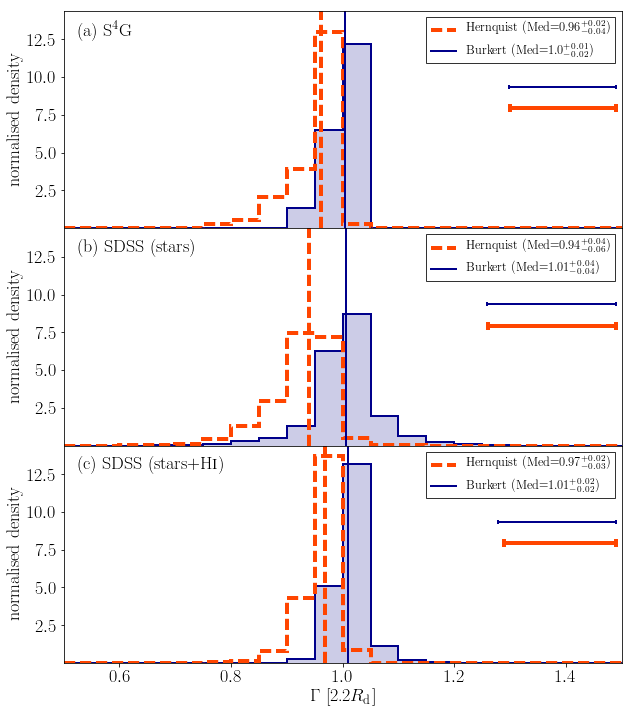

In [14]:
bins = np.linspace(0.5,1.5,21)
psi_obs = [np.array(s4g_psis['P_abs'][has_psi_s4g]),
           np.array(gz2_psis['P_wtd_avg'][has_psi_gz2]),
           np.array(gz2_psis['P_wtd_avg'][has_psi_gz2])]

Gamma_fake = np.ones(10) * 50

c = ComparisonPlotter(Gamma_fake,bins,[r'S$^4$G',
                                       r'SDSS (stars)',
                                       r'SDSS (stars+H\textsc{i})'],
                      n_subsets=3,median_line=True)

dh = [s4g['Gamma_hernquist'][in_s4g_psi],
      sdss['Gamma_hernquist'][in_sdss_psi],
      sdss_w_gas['Gamma_hernquist'][in_sdss_psi]]

db = [s4g['Gamma_burkert'][in_s4g_psi],
      sdss['Gamma_burkert'][in_sdss_psi],
      sdss_w_gas['Gamma_burkert'][in_sdss_psi]]

eh = [s4g['delta_Gamma_hernquist'][in_s4g_psi],
      sdss['delta_Gamma_hernquist'][in_sdss_psi],
      sdss_w_gas['delta_Gamma_hernquist'][in_sdss_psi]]

eb = [s4g['delta_Gamma_burkert'][in_s4g_psi],
      sdss['delta_Gamma_burkert'][in_sdss_psi],
      sdss_w_gas['delta_Gamma_burkert'][in_sdss_psi]]

_ = c.make_axes('$\Gamma$ [2.2$R_\mathrm{d}$]',
                'normalised density',dlabels=dlabels,plot_comparison=False)

c.histogram(db,color='darkblue',lw=2,linestyle='solid',histtype='step')
c.histogram(db,color='darkblue',alpha=0.2,histtype='stepfilled')
c.histogram(dh,color='orangered',linestyle='dashed',lw=4,histtype='step')

c.errorbar(eh,(0.99,0.55),0.5,
           color='orangered',linestyle='dashed',lw=4,
           capthick=4,capsize=4)
c.errorbar(eb,(0.99,0.65),0.5,
           color='darkblue',lw=2,linestyle='solid',
           capthick=2,capsize=2)

c.label_maker(dh,label='Hernquist',color='orangered',linestyle='dashed',
              lw=4,ks=False)
c.label_maker(db,label='Burkert',color='darkblue',lw=2,linestyle='solid',
              ks=False)

for ax in c.axarr:
    ax.legend(fontsize=12.5,fancybox=False,edgecolor='k')
    
c.fig.savefig('figures/Gamma_distributions.pdf')